<a href="https://colab.research.google.com/github/rafalopes74/EnergyConsumptionAI/blob/main/multi_step_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

In [185]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

plt.style.use('ggplot')

In [186]:
!wget --no-clobber https://raw.githubusercontent.com/rafalopes74/EnergyConsumptionAI/main/DAYTON_hourly.csv

File ‘DAYTON_hourly.csv’ already there; not retrieving.



In [187]:
data = pd.read_csv("/content/DAYTON_hourly.csv", header = 'infer', parse_dates = True)
data['Datetime'] = pd.to_datetime(data['Datetime'])
data = data.set_index("Datetime")

data.resample('3H').sum()
#data = data.resample('6H').sum()
#data = data.resample('12H').sum()
#data.resample('1D').sum()
#data.resample('1W').sum()
#data.resample('1Y').sum()
#data.groupby([data.index.year == 2015,data.index.month <3 ])['DAYTON_MW'].sum()

,DAYTON_MW
Datetime,
2004-10-01 00:00:00,3157.0
2004-10-01 03:00:00,4423.0
2004-10-01 06:00:00,5486.0
2004-10-01 09:00:00,6209.0
2004-10-01 12:00:00,6450.0
...,...
2018-08-02 12:00:00,7269.0
2018-08-02 15:00:00,7796.0
2018-08-02 18:00:00,7778.0


In [188]:
data.shape

(121275, 1)

In [189]:
data.tail(5)

,DAYTON_MW
Datetime,
2018-01-01 20:00:00,2732.0
2018-01-01 21:00:00,2724.0
2018-01-01 22:00:00,2664.0
2018-01-01 23:00:00,2614.0
2018-01-02 00:00:00,2552.0


In [190]:
data = data[data.index.year >= 2012]

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)

In [191]:
train, test = train_test_split(normalized_data, test_size = 0.2, shuffle = False)
print(len(data), len(train), len(test))

57740 46192 11548


  Hyper parameters

In [192]:
n_steps_in = 24
n_steps_out = 8
lag = 0

n_epochs = 10
learn_rate = 0.002

Model

In [193]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, 1)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

my_optimizer = Adam(lr=learn_rate)
model.compile(optimizer=my_optimizer, loss='mse')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [194]:
def split_sequence(sequence, n_steps_in, n_steps_out, lag = 0):
  X, y = list(), list()
  i = 0
  while i < len(sequence):
    # find the end of this pattern
    end_ix = i + n_steps_in
    out_end_ix = end_ix + n_steps_out

    # check if we are beyond the sequence
    if out_end_ix + lag > len(sequence):
      break

    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix + lag:out_end_ix + lag]
    i = i + n_steps_out
    X.append(seq_x)
    y.append(seq_y)
  
  return np.array(X), np.array(y)

In [195]:
# split into samples
trainX, trainY = split_sequence(train, n_steps_in, n_steps_out)
testX, testY = split_sequence(test, n_steps_in, n_steps_out)

trainX = trainX.reshape((trainX.shape[0], trainX.shape[1], 1))
testX = testX.reshape((testX.shape[0], testX.shape[1], 1))

In [196]:
%%time
summary = model.fit(trainX, trainY, epochs=n_epochs)

Epoch 1/10
181/181 [==============================] - 7s 24ms/step - loss: 0.0240
Epoch 2/10
181/181 [==============================] - 5s 28ms/step - loss: 0.0155
Epoch 3/10
181/181 [==============================] - 4s 24ms/step - loss: 0.0082
Epoch 4/10
181/181 [==============================] - 4s 22ms/step - loss: 0.0056
Epoch 5/10
181/181 [==============================] - 4s 23ms/step - loss: 0.0047
Epoch 6/10
181/181 [==============================] - 4s 23ms/step - loss: 0.0042
Epoch 7/10
181/181 [==============================] - 4s 22ms/step - loss: 0.0039
Epoch 8/10
181/181 [==============================] - 4s 23ms/step - loss: 0.0036
Epoch 9/10
181/181 [==============================] - 4s 23ms/step - loss: 0.0036
Epoch 10/10
181/181 [==============================] - 4s 22ms/step - loss: 0.0036
CPU times: user 1min 14s, sys: 1.7 s, total: 1min 15s
Wall time: 45.3 s


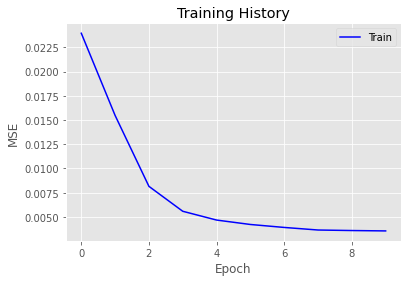

In [197]:
plt.plot(summary.history['loss'], c="b")
plt.title('Training History')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [198]:
trainPredict = model.predict(trainX, verbose=0)
testPredict = model.predict(testX, verbose=0)

Performance

In [199]:
trainRMSE = np.sqrt(mean_squared_error(trainY.flatten(), trainPredict.flatten()))
print('Test Score:')
print('   %.3f RMSE' % (trainRMSE))

testRMSE = np.sqrt(mean_squared_error(testY.flatten(), testPredict.flatten()))
print('Test Score:')
print('   %.3f RMSE' % (testRMSE))

Test Score:
   0.065 RMSE
Test Score:
   0.066 RMSE


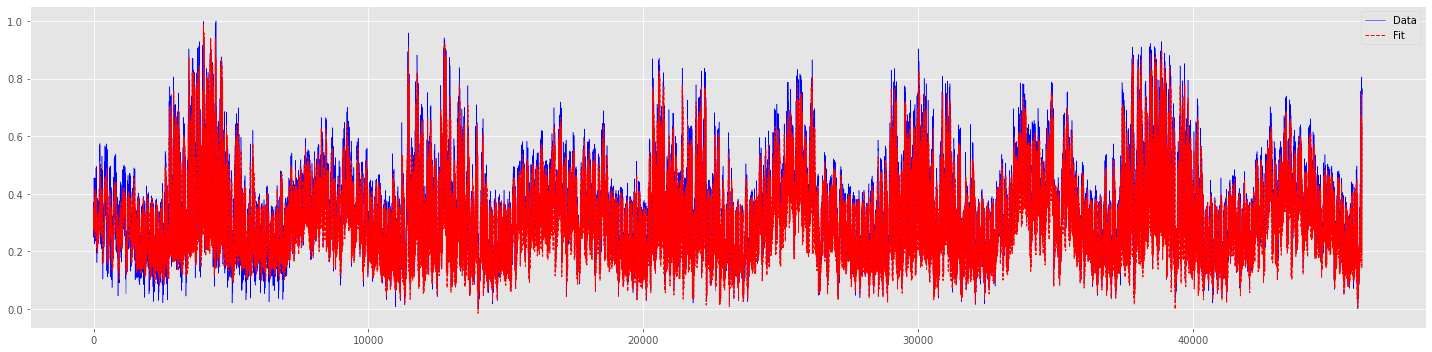

In [200]:
# Compare the training prediction

plt.figure(figsize = (20, 5))

plt.plot(trainY.flatten(), c='b',linewidth=0.5, linestyle="-",label="Data")
plt.plot(trainPredict.flatten(), c='r',linewidth=1, linestyle="--",label="Fit")

plt.legend()
plt.tight_layout()
plt.show()

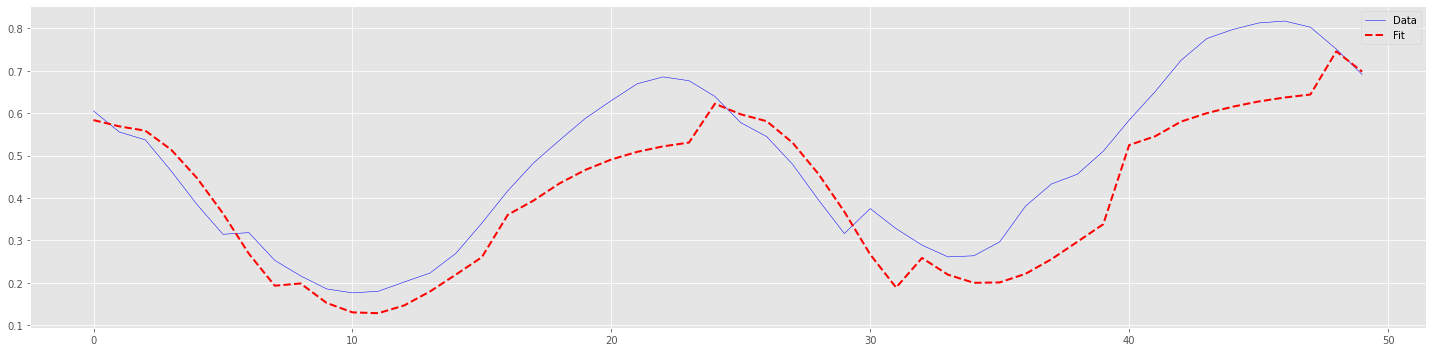

In [201]:
# Compare the test prediction

plt.figure(figsize = (20, 5))

plt.plot(testY.flatten()[:50], c='b',linewidth=0.5, linestyle="-",label="Data")
plt.plot(testPredict.flatten()[:50], c='r',linewidth=2, linestyle="--",label="Fit")

plt.legend()
plt.tight_layout()
plt.show()